In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
# !unzip '/content/gdrive/My Drive/lab3-nvidia-chula.zip'

In [4]:
# Downgrade Pillow to avoid errors
!pip install Pillow==3.4.2

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from time import time

from numpy.random import seed
seed(12)
# from tensorflow import set_random_seed
# set_random_seed(12)
tf.random.set_seed(12)

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)

from sklearn.metrics import classification_report, f1_score, accuracy_score
import glob
from tqdm import tqdm
import warnings

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Variable path Setting
- training, validation, testing and model path directories.

In [5]:
train_dir = "./dataset/lab3-1/10_flower/train"
val_dir = "./dataset/lab3-1/10_flower/validate"
test_dir = "./dataset/lab3-1/10_flower/test"

## Data preprocessing

Read training and validation dataset
- Data augmentation strategies using ImageDataGenerator

In [6]:
image_size = 224
num_class = 10

batch_size=32

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical')

Found 480 images belonging to 10 classes.
Found 160 images belonging to 10 classes.


In [7]:
x, y = train_generator.next()

Define f1_score metric for evaluating model 

In [10]:
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    # f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

## Model 1
- VGG19 (random initialized weights) + 2 Dense layers + Output layer

In [29]:
base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=0, mode='max')

model_1_path = "./model/lab3_1/{}.h5".format("model_1")
checkpoint = ModelCheckpoint(model_1_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_1 = Model(inputs=base_model.input, outputs=output)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
# pretrined_model_1_path = "./model/const_models/lab3_1/model_1.h5"
# model_1.load_weights(pretrined_model_1_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_1.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps
        )

Epoch 1/5
8/7 [================================] - 6s 728ms/step - loss: 2.3616 - accuracy: 0.1055 - f1_score_metric: 0.0000e+00 - val_loss: 2.2986 - val_accuracy: 0.0833 - val_f1_score_metric: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.08333, saving model to ./model/lab3_1/model_1.h5
Epoch 2/5
8/7 [================================] - 4s 509ms/step - loss: 2.3013 - accuracy: 0.0977 - f1_score_metric: 0.0000e+00 - val_loss: 2.2707 - val_accuracy: 0.1562 - val_f1_score_metric: 0.0000e+00

Epoch 00002: val_accuracy improved from 0.08333 to 0.15625, saving model to ./model/lab3_1/model_1.h5
Epoch 3/5
8/7 [================================] - 4s 507ms/step - loss: 2.2287 - accuracy: 0.1523 - f1_score_metric: 0.0000e+00 - val_loss: 2.1257 - val_accuracy: 0.3125 - val_f1_score_metric: 0.0417

Epoch 00003: val_accuracy improved from 0.15625 to 0.31250, saving model to ./model/lab3_1/model_1.h5
Epoch 4/5
8/7 [================================] - 4s 557ms/step - loss: 2.0229 - a

## Model 2
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- Freezes all weights of base model layers

In [30]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=20, verbose=0, mode='max')

model_2_path = "./model/lab3_1/{}.h5".format("model_2")
checkpoint = ModelCheckpoint(model_2_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_2 = Model(inputs=base_model.input, outputs=output)
model_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
# pretrined_model_2_path = "./model/const_models/lab3_1/model_2.h5"
# model_2.load_weights(pretrined_model_2_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_2.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps
        )

Epoch 1/5
8/7 [================================] - 5s 605ms/step - loss: 38.3769 - accuracy: 0.2891 - f1_score_metric: 0.2891 - val_loss: 13.3113 - val_accuracy: 0.5938 - val_f1_score_metric: 0.5938

Epoch 00001: val_accuracy improved from -inf to 0.59375, saving model to ./model/lab3_1/model_2.h5
Epoch 2/5
8/7 [================================] - 4s 488ms/step - loss: 15.2986 - accuracy: 0.5703 - f1_score_metric: 0.5703 - val_loss: 9.0513 - val_accuracy: 0.7188 - val_f1_score_metric: 0.7188

Epoch 00002: val_accuracy improved from 0.59375 to 0.71875, saving model to ./model/lab3_1/model_2.h5
Epoch 3/5
8/7 [================================] - 4s 462ms/step - loss: 8.7049 - accuracy: 0.7539 - f1_score_metric: 0.7539 - val_loss: 5.2116 - val_accuracy: 0.8333 - val_f1_score_metric: 0.8333

Epoch 00003: val_accuracy improved from 0.71875 to 0.83333, saving model to ./model/lab3_1/model_2.h5
Epoch 4/5
8/7 [================================] - 4s 510ms/step - loss: 4.2314 - accuracy: 0.8125 -

## Model 3
- VGG19 (pre-trained weights) + 2 Dense layers + Output layer
- use basic Fine-tuning technique which unfreezes all layers.

In [31]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=0, mode='max')

model_3_path = "./model/lab3_1/{}.h5".format("model_3")
checkpoint = ModelCheckpoint(model_3_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_3 = Model(inputs=base_model.input, outputs=output)
model_3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_3_path = "./model/const_models/lab3_1/model_3.h5"
model_3.load_weights(pretrined_model_3_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
history = model_3.fit_generator(
                    train_generator,
                    steps_per_epoch=stepsPerEpoch,
                    epochs=5,
                    callbacks = callbacks_list,
                    validation_data = validation_generator,
                    validation_steps=validationSteps
                    )

Epoch 1/5
8/7 [================================] - 6s 736ms/step - loss: 0.2642 - accuracy: 0.9375 - f1_score_metric: 0.9297 - val_loss: 0.3910 - val_accuracy: 0.8646 - val_f1_score_metric: 0.8438

Epoch 00001: val_accuracy improved from -inf to 0.86458, saving model to ./model/lab3_1/model_3.h5
Epoch 2/5
8/7 [================================] - 4s 526ms/step - loss: 0.1225 - accuracy: 0.9492 - f1_score_metric: 0.9297 - val_loss: 0.5389 - val_accuracy: 0.8333 - val_f1_score_metric: 0.8333

Epoch 00002: val_accuracy did not improve from 0.86458
Epoch 3/5
8/7 [================================] - 5s 584ms/step - loss: 0.2542 - accuracy: 0.9141 - f1_score_metric: 0.9062 - val_loss: 0.6157 - val_accuracy: 0.8229 - val_f1_score_metric: 0.8125

Epoch 00003: val_accuracy did not improve from 0.86458
Epoch 4/5
8/7 [================================] - 5s 606ms/step - loss: 0.2472 - accuracy: 0.9258 - f1_score_metric: 0.9219 - val_loss: 0.8939 - val_accuracy: 0.8750 - val_f1_score_metric: 0.8750


In [19]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'val_f1_score_metric', 'loss', 'accuracy', 'f1_score_metric', 'lr'])

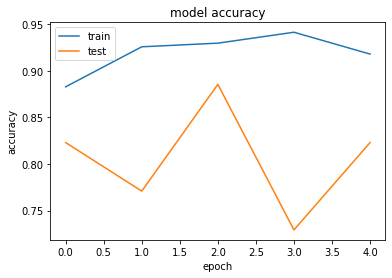

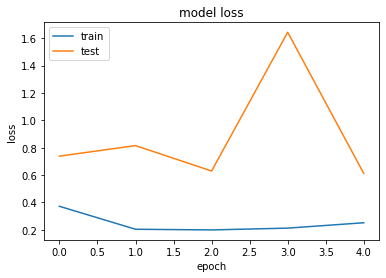

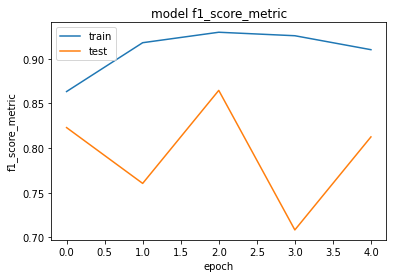

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1_score
plt.plot(history.history['f1_score_metric'])
plt.plot(history.history['val_f1_score_metric'])
plt.title('model f1_score_metric')
plt.ylabel('f1_score_metric')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- use `Chain-thaw` Fine-tuning technique, referenced by [Using millions of emoji occurrences to learn any-domain representations for detecting sentiment, emotion and sarcasm](https://arxiv.org/pdf/1708.00524.pdf).

In [21]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Create  model
model_4 = Model(inputs=base_model.input, outputs=output)

num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size

base_model_layers = model_4.layers[:23]
new_model_layers =  model_4.layers[23:]

base_model_blocks = {
    0: base_model_layers[1:3],
    1: base_model_layers[4:6],
    2: base_model_layers[7:11],
    3: base_model_layers[12:16],
    4: base_model_layers[17:21]
}

In [ ]:
# print("\n--[Phase 1]--: Train only new layers")

# for layer in base_model_layers:
#     layer.trainable = False

# # Callbacks
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
#                                 verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
# early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
#                            patience=25, verbose=0, mode='max')

# model_4_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/{}.h5".format("model_4_1")))
# checkpoint = ModelCheckpoint(model_4_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
# callbacks_list = [checkpoint,early_stopper,reduce_lr]
    
# model_4.compile(loss="categorical_crossentropy",
#               optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy", f1_score_metric])

# model_4.fit_generator(
#     train_generator,
#     steps_per_epoch=stepsPerEpoch,
#     epochs=50,
#     callbacks=callbacks_list,
#     validation_data=validation_generator,
#     validation_steps=validationSteps
#     )

In [ ]:
# print("\n--[Phase 2]--: Train every CNN blocks of base model (5 blocks)")

# model_4_prev_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/model_4_1.h5"))
# print("Loading the previous weight from {}.".format(model_4_prev_path))
# model_4.load_weights(model_4_prev_path)

# for layer in new_model_layers:
#     layer.trainable = False

# for idx in range(0, 5):
#     # train idx block
#     print("[Train block{}]: containing {} layers".format(idx, len(base_model_blocks[idx])))
    
#     # Callbacks
#     reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=4,
#                                     verbose=1, min_delta=0.0001, cooldown=2, min_lr=0)
#     early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
#                                patience=10, verbose=0, mode='max')

#     model_4_path = os.path.abspath(os.path.join(curr_dir, f"./model/const_models/lab3_1/model_4_2_{idx}.h5"))
#     checkpoint = ModelCheckpoint(model_4_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
#     callbacks_list = [checkpoint,early_stopper,reduce_lr]

#     for layer in base_model_layers:
#         if layer in base_model_blocks[idx]:
#             layer.trainable = True
#             print("train {}".format(layer))
#         else:
#             layer.trainable = False
#     model_4.compile(loss="categorical_crossentropy",
#                   optimizer=optimizers.Adam(lr=0.000001), metrics=["accuracy", f1_score_metric])
#     model_4.fit_generator(
#         train_generator,
#         steps_per_epoch=stepsPerEpoch,
#         epochs=50,
#         callbacks=callbacks_list,
#         validation_data=validation_generator,
#         validation_steps=validationSteps
#     )

## `To do` 

You are supposed to implement `Chain-thaw` Fine-tuning technique in the last phase which is to unfreeze all of model layers and train it to be well adapted to the target task.

HINT: you should load the last epoch model weights from provided const-model folder before training model with `fit_generator` function from the code below.


```python
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)
```


Noted that there are still needs for both `ModelCheckpoint` callback, saving model to the path, and `EarlyStopping` is still required.

The solution can be seen in the cell below.

In [24]:
print("--[Phase 3]--: Train all layers")

for layer in model_4.layers:
    layer.trainable = True


# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')
model_4_path = "./model/lab3_1/{}.h5".format("model_4")
checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]


model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])


# Load last epoch model

pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)


model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)

--[Phase 3]--: Train all layers
Epoch 1/5
8/7 [================================] - 6s 705ms/step - loss: 2.7148 - accuracy: 0.9727 - f1_score_metric: 0.9727 - val_loss: 3.3530 - val_accuracy: 0.9167 - val_f1_score_metric: 0.9167

Epoch 00001: val_f1_score_metric improved from -inf to 0.91667, saving model to ./model/lab3_1/model_4.h5
Epoch 2/5
8/7 [================================] - 4s 508ms/step - loss: 1.3651 - accuracy: 0.9688 - f1_score_metric: 0.9688 - val_loss: 6.1141 - val_accuracy: 0.9062 - val_f1_score_metric: 0.9062

Epoch 00002: val_f1_score_metric did not improve from 0.91667
Epoch 3/5
8/7 [================================] - 5s 564ms/step - loss: 0.0872 - accuracy: 0.9922 - f1_score_metric: 0.9922 - val_loss: 3.7609 - val_accuracy: 0.8958 - val_f1_score_metric: 0.8958

Epoch 00003: val_f1_score_metric did not improve from 0.91667
Epoch 4/5
8/7 [================================] - 5s 586ms/step - loss: 1.1506 - accuracy: 0.9805 - f1_score_metric: 0.9805 - val_loss: 0.4080 

<details>
    <summary>SOLUTION HERE!</summary>
    <pre>
        <code>

for layer in model_4.layers:
    layer.trainable = True

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')
model_4_path = "./model/lab3_1/{}.h5".format("model_4")
checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)

model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)
        </code>
    </pre>
</details>

## Evaluation
-  `F-score` is really useful if you want to compare 2 classifiers. It is computed using the harmonic mean of precision and recall, and gives much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high. You can easily compute the F-Score with sklearn.
- `Micro F1-score` is to calculate metrics globally by counting the total true positives, false negatives and false positives, while 
- `Macro F1-score` is to calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [25]:
class_to_idx = train_generator.class_indices
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [26]:
idx_to_class

{0: 'class_1',
 1: 'class_10',
 2: 'class_2',
 3: 'class_3',
 4: 'class_4',
 5: 'class_5',
 6: 'class_6',
 7: 'class_7',
 8: 'class_8',
 9: 'class_9'}

In [32]:
# Load the best model
model_1_path = "./model/lab3_1/{}.h5".format("model_1")
model_2_path = "./model/lab3_1/{}.h5".format("model_2")
model_3_path = "./model/lab3_1/{}.h5".format("model_3")
model_4_path = "./model/lab3_1/{}.h5".format("model_4")

model_1.load_weights(model_1_path)
model_2.load_weights(model_2_path)
model_3.load_weights(model_3_path)
model_4.load_weights(model_4_path)

In [33]:
# Prepare in case of problem
# model.load(model_path)

idx_to_model = {
    1: model_1,
    2: model_2,
    3: model_3,
    4: model_4
}
idx_to_preds = {
    1: ([], []), # y_trues, y_preds
    2: ([], []),
    3: ([], []),
    4: ([], [])
}

for class_idx in tqdm(range(num_class)):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.jpg".format(test_dir, label))
    for raw_image in file_list:
        inputShape = (224,224) # Assumes 3 channel image
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)   # shape is (224,224,3)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)  # Now shape is (1,224,224,3)

        for model_idx in range(1, 5):
            model = idx_to_model[model_idx]
            preds = model.predict(image)
            pred_class = np.argmax(preds)

            # append y_trues
            idx_to_preds[model_idx][0].append(class_idx)
            # append y_preds
            idx_to_preds[model_idx][1].append(pred_class)

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Performace of each models:")
    for idx in range(1, 5):
      
        y_trues = idx_to_preds[idx][0]
        y_preds = idx_to_preds[idx][1]
        print("-- Model_{} (acc:{:.4f}, f1_micro:{:.4f}, f1_macro:{:.4f})".format(idx,
                                                                                accuracy_score(y_trues, y_preds), 
                                                                                f1_score(y_trues, y_preds, average='micro'),
                                                                                f1_score(y_trues, y_preds, average='macro')))

Performace of each models:
-- Model_1 (acc:0.2250, f1_micro:0.2250, f1_macro:0.1211)
-- Model_2 (acc:0.8000, f1_micro:0.8000, f1_macro:0.7826)
-- Model_3 (acc:0.7188, f1_micro:0.7188, f1_macro:0.7175)
-- Model_4 (acc:0.8438, f1_micro:0.8438, f1_macro:0.8397)


## Result
to see how the model perform by testing sample visualized by matplotlib.

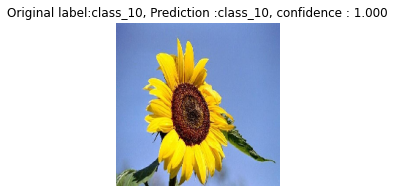

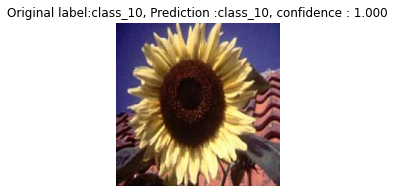

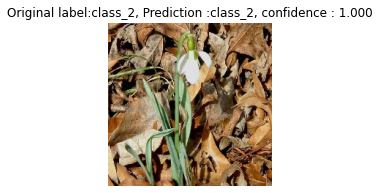

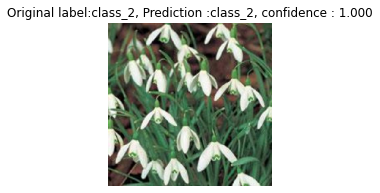

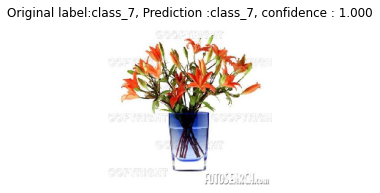

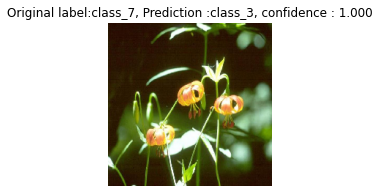

In [35]:
import random

for class_idx in random.sample(range(0, num_class), 3):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.jpg".format(test_dir, label))
    for raw_image in file_list[:2]:
        inputShape = (224,224)
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        preds = model_4.predict(image)

        pred_class = np.argmax(preds)
        pred_label = idx_to_class[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            label,
            pred_label,
            preds[0][pred_class])

        original = load_img(raw_image, target_size=(224, 224))
        plt.figure(figsize=[3,3])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()